In [20]:
#list all json files
#read json files
#remove points in buffer region
#count points

In [1]:
import json
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
json_path = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/roi'
ref_ffn   = '/g/data1a/kl02/jss548/hail-research/HailPixel/subsets/index.csv'
filter_ffn   = '/home/548/jss548/dev/SevereWeather/hailpixel/postprocessing/hq_subset_list.txt'

In [3]:
#read reference file
df = pd.read_csv(ref_ffn, header=0)
ref_dict = df.to_dict(orient='list')

In [4]:
#read subset_list file
with open(filter_ffn, 'r') as f:
    subset_list = f.read().splitlines()

In [5]:
hail_count   = 0
hail_skipped = 0
buffer_px    = 50
hail_x       = []
hail_y       = []
hq_x         = []
hq_y         = []
hq_id        = []

json_ffn_list = glob.glob(json_path + '/*.json')

for json_ffn in json_ffn_list:
    #print('reading:', json_ffn)
    #read json file 
    with open(json_ffn) as json_fh:  
        data = json.load(json_fh)
    #extract json header name
    json_header = next(iter(data))
    #extract list of regions
    point_list = data[json_header]['regions']
    #find reference x0 and y0 points
    subset_idx = os.path.basename(json_ffn)[0:4]
    
    ref_idx    = ref_dict['idx'].index(int(subset_idx))
    x0 = ref_dict['x0'][ref_idx]
    y0 = ref_dict['y0'][ref_idx]
    
    if subset_idx in subset_list:
        hq_x.append(x0 + 250)
        hq_y.append(y0 + 250)
        hq_id.append(subset_idx)
        
    #for every region
    for point in point_list:
        #extract points
        cx = point['shape_attributes']['cx']
        cy = point['shape_attributes']['cy']
        #check if in padded regions
        if cx < 50 or cx > 550 or cy < 50 or cy > 550:
            hail_skipped += 1
            continue
        else:
            #add to lists
            hail_count += 1
            hail_x.append(x0+cx)
            hail_y.append(y0+cy)
            

    
print('final hail count:', hail_count)
print('final hail skipped:', hail_skipped)

    


final hail count: 56932
final hail skipped: 22028


In [6]:
hail_x_m = np.array(hail_x) * 0.0025
hail_y_m = np.array(hail_y) * 0.0025

hq_x_m = np.array(hq_x) * 0.0025
hq_y_m = np.array(hq_y) * 0.0025


In [7]:
print(500*0.0025) #size of subsets in m

1.25


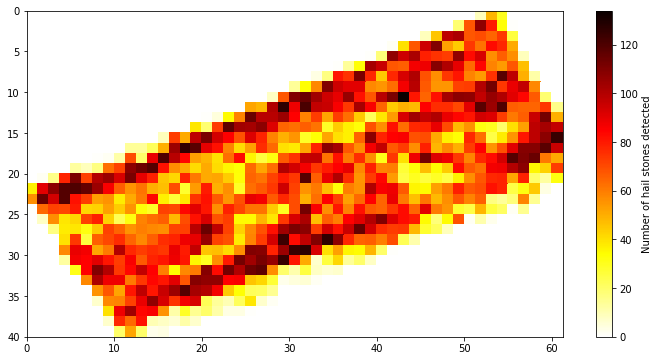

In [8]:
xbins = np.arange(0, 62.5, 1.25) 
ybins = np.arange(0, 41, 1.25)

#compute 2d hist matrix
counts, _, _ = np.histogram2d(hail_x_m, hail_y_m, bins=(xbins, ybins))

#plot 2d hist matrix 
fig = plt.figure(facecolor='white',figsize=[12,6])
ax = plt.subplot(1, 1, 1)
im = ax.pcolormesh(xbins, ybins, counts.T, cmap='hot_r') #pcolormesh expect Y,X axes order
plt.ylim(40, 0)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Number of hail stones detected')

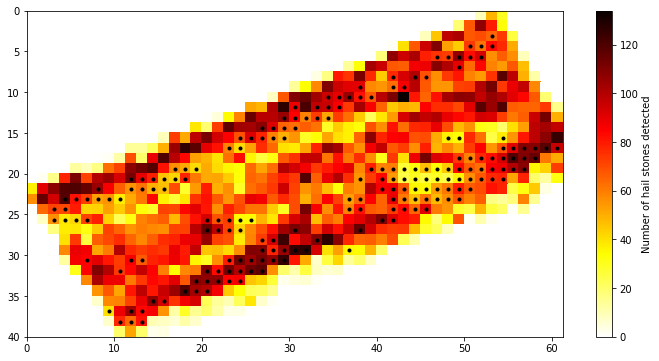

In [9]:
xbins = np.arange(0, 62.5, 1.25) 
ybins = np.arange(0, 41, 1.25)

#compute 2d hist matrix
counts, _, _ = np.histogram2d(hail_x_m, hail_y_m, bins=(xbins, ybins))

#plot 2d hist matrix 
fig = plt.figure(facecolor='white',figsize=[12,6])
ax = plt.subplot(1, 1, 1)
im = ax.pcolormesh(xbins, ybins, counts.T, cmap='hot_r') #pcolormesh expect Y,X axes order
plt.ylim(40, 0)

#plot markers where for HQ subsets
ax.plot(hq_x_m, hq_y_m,'k.')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Number of hail stones detected')

In [10]:
#create interactive heatmap with maerks showing subset if of high quality subsets

from plotly.offline import plot
import plotly.graph_objs as go


trace1 = go.Heatmap(z=counts.T, x=xbins, y=ybins, hoverinfo='none', colorscale='hot_r')
trace2 = go.Scatter(x = hq_x_m, y = hq_y_m, text = hq_id, hoverinfo='text', mode = 'markers', marker=dict(color='black'))
layout= go.Layout(hovermode= 'closest', yaxis = dict(autorange = "reversed"))
    
fig= go.Figure(data=[trace1, trace2], layout=layout)
plot(fig, filename='heatmap.html')

'file:///home/548/jss548/dev/SevereWeather/hailpixel/postprocessing/heatmap.html'